In [6]:
!pip install openfe

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import optuna

Данная часть выполнялась на ресурсе kaggle:
- Отфильтрованные данные: https://www.kaggle.com/datasets/maxigitov/a-data-filtered
- Сабмит: https://www.kaggle.com/datasets/maxigitov/submit-test

In [3]:
data_filtered_train = pd.read_csv(r'/kaggle/input/a-data-filtered/data_train_filtered.csv')
data_filtered_test = pd.read_csv(r'/kaggle/input/a-data-filtered/data_test_filtered.csv')

Функция генерации доп. колонок при помощи библиотеки openfe
- Ссылка на модель: https://www.kaggle.com/models/maxigitov/rl_features

In [4]:
def transofrm_openfe(X):
    from openfe import transform 
    import pickle
    with open('/kaggle/input/rl_features/other/default/1/features_mazafuq_2.pkl', 'rb') as model_file:
        features_ = pickle.load(model_file)

    X, X = transform(X, X, features_, n_jobs=4)

    return X

In [7]:
data_filtered_train = transofrm_openfe(data_filtered_train)
data_filtered_test = transofrm_openfe(data_filtered_test)

In [11]:
data_filtered_train.tail()

,feature_2,feature_7,feature_11,feature_13,feature_18,feature_21,feature_24,feature_27,feature_28,feature_30,...,autoFE_f_1978,autoFE_f_1979,autoFE_f_1980,autoFE_f_1981,autoFE_f_1982,autoFE_f_1983,autoFE_f_1984,autoFE_f_1985,autoFE_f_1986,autoFE_f_1987
30979,-0.690403,0.007990,0.871033,-0.165979,-0.223120,0,0.797979,-0.730385,0.239400,0.689414,...,0.346349,0.089275,0.029038,0.082580,-0.184634,0.068077,0.219669,1.055902,1.978332,2.146515
30980,0.782564,1.831460,2.377896,-0.462439,-0.209365,0,1.178892,2.205910,-0.306975,1.127020,...,1.286494,0.032636,3.380849,-0.743008,0.105139,0.794264,3.756926,-0.002062,0.355291,3.976184
30981,0.008755,1.337855,0.025678,-1.077105,0.403857,0,-0.693818,0.390232,0.520592,0.606341,...,0.839583,-0.027921,-0.041694,-3.011512,-1.199338,0.204207,0.498676,-0.198459,0.520592,-0.295965
30982,0.069798,0.590845,-0.178677,1.552149,0.503299,2,-1.969991,0.945161,1.687895,0.096942,...,0.206439,-0.094256,-0.367242,0.922389,-2.187992,0.411301,0.433067,0.299950,1.687895,-0.107072
30983,-0.483061,0.669237,1.433885,-0.246306,-1.572928,0,0.524722,0.072346,0.725533,0.733642,...,1.113729,-0.027921,-0.681565,-0.855400,-0.361922,0.457600,0.708487,2.129807,0.725533,1.243527


В время решения подбор гиперпараметров optuna осуществлялся через представленную сетку. Для воспроизводимости решения, предоставляем подобранные гиперпараметры:
- { 'learning_rate': 0.011608443347858289, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8111071406017442, 'colsample_bytree': 0.9253272092863656, 'gamma': 0.706494905024926, 'reg_alpha': 1.75928773021309e-07, 'reg_lambda': 2.942601302437469 }

## Feature filtration by permutation importance

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import optuna

def train_and_evaluate_xgboost(data_train, data_test, n_trials=20, timeout=600):
    # Проверка наличия целевой переменной и разделение данных
    if 'target' in data_train.columns and 'target' in data_test.columns:
        X_train = data_train.drop(columns=['target'])
        y_train = data_train['target']
        X_test = data_test.drop(columns=['target'])
        y_test = data_test['target']
    else:
        raise ValueError("Ошибка: отсутствует столбец 'target' в train или test данных.")

    # Определение категориальных признаков
    categorical_columns = [col for col in X_train.columns if X_train[col].nunique() < 30]

    # Кодирование категориальных признаков
    for col in categorical_columns:
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

    def optimize_xgb(trial):
        params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
        }

        model = xgb.XGBClassifier(
            **params,
            objective='binary:logistic',
            n_estimators=500,
            tree_method='gpu_hist',
            gpu_id=0,
            verbosity=0,
            use_label_encoder=False
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train)],
            eval_metric='auc',
            verbose=False
        )

        preds = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        return score

    # Создание и запуск Optuna исследований
    def run_optuna(study_name, optimize_function, n_trials=20, timeout=None):
        study = optuna.create_study(direction='maximize', study_name=study_name)
        study.optimize(optimize_function, n_trials=n_trials, timeout=timeout)
        return study.best_params

    # Подбор гиперпараметров
    # best_params_xgb = run_optuna('XGBoost', optimize_xgb, n_trials=n_trials, timeout=timeout)
    best_params_xgb = { 'learning_rate': 0.011608443347858289, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8111071406017442, 'colsample_bytree': 0.9253272092863656, 'gamma': 0.706494905024926, 'reg_alpha': 1.75928773021309e-07, 'reg_lambda': 2.942601302437469 }
    # Обучение модели с лучшими гиперпараметрами
    xgb_model = xgb.XGBClassifier(
        **best_params_xgb,
        objective='binary:logistic',
        n_estimators=500,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=0,
        use_label_encoder=False
    )
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],
        eval_metric='auc',
        verbose=False
    )

    # Предсказания модели
    preds_xgb = xgb_model.predict_proba(X_test)[:, 1]

    # Оценка модели
    roc_auc = roc_auc_score(y_test, preds_xgb)
    print(f"ROC-AUC score (без перемешивания): {roc_auc:.4f}")

    # Вычисление Permutation Importance
    perm_importance = permutation_importance(xgb_model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42)

    # Сохранение названий колонок с отрицательным приростом
    negative_importance_columns = [col for col, importance in zip(X_test.columns, perm_importance.importances_mean) if importance < 0]
    
    # Удаление этих колонок из обучающего и тестового наборов
    X_train = X_train.drop(columns=negative_importance_columns)
    X_test = X_test.drop(columns=negative_importance_columns)

    # Сохранение обновленных данных
    data_train_filtered = pd.concat([X_train, y_train], axis=1)
    data_test_filtered = pd.concat([X_test, y_test], axis=1)
    
    data_train_filtered.to_csv('data_train_filtered.csv', index=False)
    data_test_filtered.to_csv('data_test_filtered.csv', index=False)
    
    print(f"Удаленные признаки с отрицательным влиянием: {negative_importance_columns}")
    return roc_auc, negative_importance_columns

# Пример использования функции
roc_auc, negative_importance_columns = train_and_evaluate_xgboost(data_filtered_train, data_filtered_test)

ROC-AUC score (без перемешивания): 0.7922
Удаленные признаки с отрицательным влиянием: ['feature_2', 'feature_13', 'feature_18', 'feature_24', 'feature_27', 'feature_31', 'feature_34', 'feature_41', 'feature_45', 'feature_58', 'feature_61', 'feature_69', 'feature_75', 'feature_78', 'feature_81', 'feature_90', 'feature_93', 'feature_94', 'feature_100', 'feature_108', 'feature_110', 'feature_116', 'feature_122', 'feature_124', 'feature_127', 'feature_131', 'feature_134', 'feature_144', 'feature_150', 'feature_159', 'feature_163', 'feature_166', 'feature_168', 'feature_170', 'feature_177', 'feature_184', 'feature_188', 'feature_190', 'feature_192', 'feature_196', 'feature_208', 'feature_209', 'feature_222', 'feature_224', 'feature_227', 'feature_228', 'feature_230', 'feature_239', 'feature_241', 'feature_245', 'feature_251', 'feature_253', 'feature_274', 'feature_283', 'feature_307', 'feature_320', 'feature_324', 'feature_326', 'feature_331', 'feature_333', 'feature_338', 'feature_344', '

In [8]:
col_to_drop = ['feature_2', 'feature_13', 'feature_18', 'feature_24', 'feature_27', 'feature_31', 'feature_34', 'feature_41', 'feature_45', 'feature_58', 'feature_61', 'feature_69', 'feature_75', 'feature_78', 'feature_81', 'feature_90', 'feature_93', 'feature_94', 'feature_100', 'feature_108', 'feature_110', 'feature_116', 'feature_122', 'feature_124', 'feature_127', 'feature_131', 'feature_134', 'feature_144', 'feature_150', 'feature_159', 'feature_163', 'feature_166', 'feature_168', 'feature_170', 'feature_177', 'feature_184', 'feature_188', 'feature_190', 'feature_192', 'feature_196', 'feature_208', 'feature_209', 'feature_222', 'feature_224', 'feature_227', 'feature_228', 'feature_230', 'feature_239', 'feature_241', 'feature_245', 'feature_251', 'feature_253', 'feature_274', 'feature_283', 'feature_307', 'feature_320', 'feature_324', 'feature_326', 'feature_331', 'feature_333', 'feature_338', 'feature_344', 'feature_345', 'feature_349', 'feature_356', 'feature_370', 'feature_371', 'feature_374', 'feature_384', 'feature_386', 'feature_388', 'feature_400', 'feature_402', 'feature_409', 'feature_418', 'autoFE_f_1', 'autoFE_f_2', 'autoFE_f_3', 'autoFE_f_5', 'autoFE_f_8', 'autoFE_f_9', 'autoFE_f_14', 'autoFE_f_15', 'autoFE_f_16', 'autoFE_f_17', 'autoFE_f_19', 'autoFE_f_20', 'autoFE_f_23', 'autoFE_f_25', 'autoFE_f_28', 'autoFE_f_32', 'autoFE_f_36', 'autoFE_f_38', 'autoFE_f_43', 'autoFE_f_47', 'autoFE_f_51', 'autoFE_f_58', 'autoFE_f_64', 'autoFE_f_65', 'autoFE_f_71', 'autoFE_f_72', 'autoFE_f_75', 'autoFE_f_77', 'autoFE_f_78', 'autoFE_f_81', 'autoFE_f_83', 'autoFE_f_88', 'autoFE_f_94', 'autoFE_f_95', 'autoFE_f_99', 'autoFE_f_100', 'autoFE_f_105', 'autoFE_f_106', 'autoFE_f_107', 'autoFE_f_108', 'autoFE_f_114', 'autoFE_f_115', 'autoFE_f_116', 'autoFE_f_118', 'autoFE_f_120', 'autoFE_f_122', 'autoFE_f_123', 'autoFE_f_125', 'autoFE_f_126', 'autoFE_f_129', 'autoFE_f_130', 'autoFE_f_133', 'autoFE_f_135', 'autoFE_f_137', 'autoFE_f_139', 'autoFE_f_143', 'autoFE_f_154', 'autoFE_f_155', 'autoFE_f_156', 'autoFE_f_157', 'autoFE_f_158', 'autoFE_f_159', 'autoFE_f_160', 'autoFE_f_161', 'autoFE_f_163', 'autoFE_f_164', 'autoFE_f_167', 'autoFE_f_169', 'autoFE_f_176', 'autoFE_f_177', 'autoFE_f_178', 'autoFE_f_184', 'autoFE_f_191', 'autoFE_f_196', 'autoFE_f_198', 'autoFE_f_199', 'autoFE_f_200', 'autoFE_f_201', 'autoFE_f_202', 'autoFE_f_203', 'autoFE_f_207', 'autoFE_f_209', 'autoFE_f_211', 'autoFE_f_212', 'autoFE_f_215', 'autoFE_f_216', 'autoFE_f_218', 'autoFE_f_220', 'autoFE_f_221', 'autoFE_f_226', 'autoFE_f_227', 'autoFE_f_231', 'autoFE_f_235', 'autoFE_f_238', 'autoFE_f_239', 'autoFE_f_240', 'autoFE_f_241', 'autoFE_f_243', 'autoFE_f_244', 'autoFE_f_248', 'autoFE_f_249', 'autoFE_f_250', 'autoFE_f_254', 'autoFE_f_256', 'autoFE_f_258', 'autoFE_f_265', 'autoFE_f_266', 'autoFE_f_268', 'autoFE_f_269', 'autoFE_f_271', 'autoFE_f_273', 'autoFE_f_274', 'autoFE_f_275', 'autoFE_f_282', 'autoFE_f_288', 'autoFE_f_291', 'autoFE_f_293', 'autoFE_f_296', 'autoFE_f_299', 'autoFE_f_300', 'autoFE_f_301', 'autoFE_f_304', 'autoFE_f_308', 'autoFE_f_309', 'autoFE_f_310', 'autoFE_f_311', 'autoFE_f_312', 'autoFE_f_313', 'autoFE_f_316', 'autoFE_f_317', 'autoFE_f_318', 'autoFE_f_320', 'autoFE_f_323', 'autoFE_f_326', 'autoFE_f_327', 'autoFE_f_328', 'autoFE_f_329', 'autoFE_f_331', 'autoFE_f_334', 'autoFE_f_339', 'autoFE_f_341', 'autoFE_f_342', 'autoFE_f_343', 'autoFE_f_345', 'autoFE_f_348', 'autoFE_f_350', 'autoFE_f_351', 'autoFE_f_353', 'autoFE_f_355', 'autoFE_f_358', 'autoFE_f_360', 'autoFE_f_362', 'autoFE_f_364', 'autoFE_f_367', 'autoFE_f_368', 'autoFE_f_369', 'autoFE_f_371', 'autoFE_f_379', 'autoFE_f_380', 'autoFE_f_383', 'autoFE_f_384', 'autoFE_f_385', 'autoFE_f_388', 'autoFE_f_391', 'autoFE_f_397', 'autoFE_f_400', 'autoFE_f_401', 'autoFE_f_404', 'autoFE_f_407', 'autoFE_f_409', 'autoFE_f_414', 'autoFE_f_416', 'autoFE_f_418', 'autoFE_f_420', 'autoFE_f_423', 'autoFE_f_424', 'autoFE_f_425', 'autoFE_f_433', 'autoFE_f_435', 'autoFE_f_437', 'autoFE_f_438', 'autoFE_f_439', 'autoFE_f_446', 'autoFE_f_448', 'autoFE_f_450', 'autoFE_f_452', 'autoFE_f_455', 'autoFE_f_458', 'autoFE_f_459', 'autoFE_f_461', 'autoFE_f_463', 'autoFE_f_464', 'autoFE_f_470', 'autoFE_f_471', 'autoFE_f_472', 'autoFE_f_473', 'autoFE_f_475', 'autoFE_f_476', 'autoFE_f_481', 'autoFE_f_484', 'autoFE_f_487', 'autoFE_f_488', 'autoFE_f_491', 'autoFE_f_493', 'autoFE_f_494', 'autoFE_f_496', 'autoFE_f_497', 'autoFE_f_503', 'autoFE_f_504', 'autoFE_f_506', 'autoFE_f_507', 'autoFE_f_508', 'autoFE_f_511', 'autoFE_f_512', 'autoFE_f_515', 'autoFE_f_518', 'autoFE_f_520', 'autoFE_f_522', 'autoFE_f_523', 'autoFE_f_525', 'autoFE_f_531', 'autoFE_f_532', 'autoFE_f_533', 'autoFE_f_534', 'autoFE_f_535', 'autoFE_f_536', 'autoFE_f_538', 'autoFE_f_541', 'autoFE_f_542', 'autoFE_f_544', 'autoFE_f_545', 'autoFE_f_546', 'autoFE_f_549', 'autoFE_f_550', 'autoFE_f_552', 'autoFE_f_556', 'autoFE_f_558', 'autoFE_f_560', 'autoFE_f_561', 'autoFE_f_563', 'autoFE_f_565', 'autoFE_f_568', 'autoFE_f_570', 'autoFE_f_571', 'autoFE_f_572', 'autoFE_f_574', 'autoFE_f_575', 'autoFE_f_577', 'autoFE_f_578', 'autoFE_f_584', 'autoFE_f_588', 'autoFE_f_591', 'autoFE_f_593', 'autoFE_f_596', 'autoFE_f_597', 'autoFE_f_598', 'autoFE_f_599', 'autoFE_f_607', 'autoFE_f_609', 'autoFE_f_611', 'autoFE_f_613', 'autoFE_f_614', 'autoFE_f_615', 'autoFE_f_616', 'autoFE_f_617', 'autoFE_f_619', 'autoFE_f_622', 'autoFE_f_627', 'autoFE_f_630', 'autoFE_f_631', 'autoFE_f_632', 'autoFE_f_635', 'autoFE_f_641', 'autoFE_f_642', 'autoFE_f_645', 'autoFE_f_649', 'autoFE_f_651', 'autoFE_f_652', 'autoFE_f_653', 'autoFE_f_663', 'autoFE_f_666', 'autoFE_f_670', 'autoFE_f_674', 'autoFE_f_676', 'autoFE_f_677', 'autoFE_f_678', 'autoFE_f_679', 'autoFE_f_681', 'autoFE_f_682', 'autoFE_f_684', 'autoFE_f_685', 'autoFE_f_687', 'autoFE_f_688', 'autoFE_f_689', 'autoFE_f_690', 'autoFE_f_693', 'autoFE_f_695', 'autoFE_f_697', 'autoFE_f_698', 'autoFE_f_701', 'autoFE_f_702', 'autoFE_f_706', 'autoFE_f_711', 'autoFE_f_712', 'autoFE_f_713', 'autoFE_f_714', 'autoFE_f_715', 'autoFE_f_717', 'autoFE_f_718', 'autoFE_f_719', 'autoFE_f_720', 'autoFE_f_721', 'autoFE_f_723', 'autoFE_f_725', 'autoFE_f_732', 'autoFE_f_733', 'autoFE_f_737', 'autoFE_f_739', 'autoFE_f_741', 'autoFE_f_742', 'autoFE_f_745', 'autoFE_f_746', 'autoFE_f_749', 'autoFE_f_752', 'autoFE_f_754', 'autoFE_f_756', 'autoFE_f_760', 'autoFE_f_762', 'autoFE_f_767', 'autoFE_f_769', 'autoFE_f_771', 'autoFE_f_776', 'autoFE_f_777', 'autoFE_f_778', 'autoFE_f_779', 'autoFE_f_781', 'autoFE_f_786', 'autoFE_f_789', 'autoFE_f_792', 'autoFE_f_793', 'autoFE_f_797', 'autoFE_f_799', 'autoFE_f_800', 'autoFE_f_803', 'autoFE_f_804', 'autoFE_f_806', 'autoFE_f_811', 'autoFE_f_818', 'autoFE_f_819', 'autoFE_f_820', 'autoFE_f_821', 'autoFE_f_828', 'autoFE_f_830', 'autoFE_f_833', 'autoFE_f_834', 'autoFE_f_838', 'autoFE_f_841', 'autoFE_f_843', 'autoFE_f_844', 'autoFE_f_845', 'autoFE_f_846', 'autoFE_f_848', 'autoFE_f_850', 'autoFE_f_852', 'autoFE_f_855', 'autoFE_f_857', 'autoFE_f_862', 'autoFE_f_864', 'autoFE_f_869', 'autoFE_f_871', 'autoFE_f_873', 'autoFE_f_874', 'autoFE_f_875', 'autoFE_f_878', 'autoFE_f_879', 'autoFE_f_881', 'autoFE_f_884', 'autoFE_f_885', 'autoFE_f_890', 'autoFE_f_893', 'autoFE_f_894', 'autoFE_f_895', 'autoFE_f_898', 'autoFE_f_899', 'autoFE_f_900', 'autoFE_f_902', 'autoFE_f_904', 'autoFE_f_906', 'autoFE_f_907', 'autoFE_f_908', 'autoFE_f_909', 'autoFE_f_910', 'autoFE_f_915', 'autoFE_f_916', 'autoFE_f_918', 'autoFE_f_919', 'autoFE_f_920', 'autoFE_f_921', 'autoFE_f_922', 'autoFE_f_924', 'autoFE_f_929', 'autoFE_f_931', 'autoFE_f_932', 'autoFE_f_933', 'autoFE_f_935', 'autoFE_f_938', 'autoFE_f_939', 'autoFE_f_940', 'autoFE_f_941', 'autoFE_f_945', 'autoFE_f_946', 'autoFE_f_947', 'autoFE_f_949', 'autoFE_f_950', 'autoFE_f_952', 'autoFE_f_953', 'autoFE_f_954', 'autoFE_f_955', 'autoFE_f_956', 'autoFE_f_958', 'autoFE_f_962', 'autoFE_f_963', 'autoFE_f_965', 'autoFE_f_968', 'autoFE_f_969', 'autoFE_f_971', 'autoFE_f_972', 'autoFE_f_975', 'autoFE_f_976', 'autoFE_f_979', 'autoFE_f_982', 'autoFE_f_983', 'autoFE_f_984', 'autoFE_f_987', 'autoFE_f_988', 'autoFE_f_990', 'autoFE_f_996', 'autoFE_f_997', 'autoFE_f_999', 'autoFE_f_1000', 'autoFE_f_1003', 'autoFE_f_1004', 'autoFE_f_1005', 'autoFE_f_1006', 'autoFE_f_1007', 'autoFE_f_1010', 'autoFE_f_1013', 'autoFE_f_1014', 'autoFE_f_1019', 'autoFE_f_1020', 'autoFE_f_1022', 'autoFE_f_1027', 'autoFE_f_1031', 'autoFE_f_1033', 'autoFE_f_1034', 'autoFE_f_1035', 'autoFE_f_1037', 'autoFE_f_1040', 'autoFE_f_1041', 'autoFE_f_1042', 'autoFE_f_1043', 'autoFE_f_1045', 'autoFE_f_1048', 'autoFE_f_1049', 'autoFE_f_1053', 'autoFE_f_1056', 'autoFE_f_1057', 'autoFE_f_1058', 'autoFE_f_1060', 'autoFE_f_1061', 'autoFE_f_1065', 'autoFE_f_1067', 'autoFE_f_1071', 'autoFE_f_1072', 'autoFE_f_1075', 'autoFE_f_1078', 'autoFE_f_1079', 'autoFE_f_1080', 'autoFE_f_1087', 'autoFE_f_1088', 'autoFE_f_1089', 'autoFE_f_1093', 'autoFE_f_1094', 'autoFE_f_1097', 'autoFE_f_1098', 'autoFE_f_1100', 'autoFE_f_1105', 'autoFE_f_1106', 'autoFE_f_1107', 'autoFE_f_1108', 'autoFE_f_1111', 'autoFE_f_1115', 'autoFE_f_1116', 'autoFE_f_1119', 'autoFE_f_1120', 'autoFE_f_1126', 'autoFE_f_1129', 'autoFE_f_1130', 'autoFE_f_1132', 'autoFE_f_1138', 'autoFE_f_1141', 'autoFE_f_1142', 'autoFE_f_1143', 'autoFE_f_1147', 'autoFE_f_1149', 'autoFE_f_1152', 'autoFE_f_1153', 'autoFE_f_1154', 'autoFE_f_1160', 'autoFE_f_1162', 'autoFE_f_1163', 'autoFE_f_1164', 'autoFE_f_1165', 'autoFE_f_1167', 'autoFE_f_1168', 'autoFE_f_1169', 'autoFE_f_1172', 'autoFE_f_1176', 'autoFE_f_1177', 'autoFE_f_1180', 'autoFE_f_1182', 'autoFE_f_1184', 'autoFE_f_1192', 'autoFE_f_1193', 'autoFE_f_1195', 'autoFE_f_1197', 'autoFE_f_1201', 'autoFE_f_1202', 'autoFE_f_1205', 'autoFE_f_1206', 'autoFE_f_1207', 'autoFE_f_1208', 'autoFE_f_1211', 'autoFE_f_1214', 'autoFE_f_1219', 'autoFE_f_1220', 'autoFE_f_1221', 'autoFE_f_1222', 'autoFE_f_1223', 'autoFE_f_1225', 'autoFE_f_1227', 'autoFE_f_1228', 'autoFE_f_1230', 'autoFE_f_1234', 'autoFE_f_1240', 'autoFE_f_1241', 'autoFE_f_1242', 'autoFE_f_1245', 'autoFE_f_1248', 'autoFE_f_1249', 'autoFE_f_1255', 'autoFE_f_1259', 'autoFE_f_1260', 'autoFE_f_1262', 'autoFE_f_1264', 'autoFE_f_1265', 'autoFE_f_1271', 'autoFE_f_1272', 'autoFE_f_1273', 'autoFE_f_1278', 'autoFE_f_1281', 'autoFE_f_1282', 'autoFE_f_1286', 'autoFE_f_1287', 'autoFE_f_1288', 'autoFE_f_1289', 'autoFE_f_1291', 'autoFE_f_1293', 'autoFE_f_1294', 'autoFE_f_1297', 'autoFE_f_1298', 'autoFE_f_1300', 'autoFE_f_1303', 'autoFE_f_1309', 'autoFE_f_1313', 'autoFE_f_1315', 'autoFE_f_1318', 'autoFE_f_1319', 'autoFE_f_1320', 'autoFE_f_1323', 'autoFE_f_1325', 'autoFE_f_1327', 'autoFE_f_1329', 'autoFE_f_1331', 'autoFE_f_1332', 'autoFE_f_1333', 'autoFE_f_1335', 'autoFE_f_1345', 'autoFE_f_1346', 'autoFE_f_1352', 'autoFE_f_1357', 'autoFE_f_1359', 'autoFE_f_1363', 'autoFE_f_1365', 'autoFE_f_1366', 'autoFE_f_1368', 'autoFE_f_1369', 'autoFE_f_1372', 'autoFE_f_1375', 'autoFE_f_1379', 'autoFE_f_1380', 'autoFE_f_1381', 'autoFE_f_1382', 'autoFE_f_1383', 'autoFE_f_1385', 'autoFE_f_1386', 'autoFE_f_1387', 'autoFE_f_1392', 'autoFE_f_1395', 'autoFE_f_1397', 'autoFE_f_1398', 'autoFE_f_1399', 'autoFE_f_1400', 'autoFE_f_1403', 'autoFE_f_1405', 'autoFE_f_1406', 'autoFE_f_1407', 'autoFE_f_1409', 'autoFE_f_1410', 'autoFE_f_1412', 'autoFE_f_1413', 'autoFE_f_1414', 'autoFE_f_1416', 'autoFE_f_1419', 'autoFE_f_1420', 'autoFE_f_1422', 'autoFE_f_1425', 'autoFE_f_1427', 'autoFE_f_1428', 'autoFE_f_1431', 'autoFE_f_1435', 'autoFE_f_1440', 'autoFE_f_1446', 'autoFE_f_1447', 'autoFE_f_1451', 'autoFE_f_1452', 'autoFE_f_1453', 'autoFE_f_1454', 'autoFE_f_1456', 'autoFE_f_1457', 'autoFE_f_1458', 'autoFE_f_1461', 'autoFE_f_1462', 'autoFE_f_1465', 'autoFE_f_1468', 'autoFE_f_1469', 'autoFE_f_1470', 'autoFE_f_1472', 'autoFE_f_1473', 'autoFE_f_1477', 'autoFE_f_1480', 'autoFE_f_1483', 'autoFE_f_1486', 'autoFE_f_1487', 'autoFE_f_1488', 'autoFE_f_1492', 'autoFE_f_1493', 'autoFE_f_1494', 'autoFE_f_1497', 'autoFE_f_1498', 'autoFE_f_1500', 'autoFE_f_1502', 'autoFE_f_1503', 'autoFE_f_1507', 'autoFE_f_1512', 'autoFE_f_1514', 'autoFE_f_1515', 'autoFE_f_1516', 'autoFE_f_1517', 'autoFE_f_1522', 'autoFE_f_1526', 'autoFE_f_1527', 'autoFE_f_1530', 'autoFE_f_1531', 'autoFE_f_1535', 'autoFE_f_1537', 'autoFE_f_1540', 'autoFE_f_1541', 'autoFE_f_1542', 'autoFE_f_1544', 'autoFE_f_1545', 'autoFE_f_1549', 'autoFE_f_1553', 'autoFE_f_1554', 'autoFE_f_1558', 'autoFE_f_1559', 'autoFE_f_1560', 'autoFE_f_1568', 'autoFE_f_1569', 'autoFE_f_1571', 'autoFE_f_1574', 'autoFE_f_1575', 'autoFE_f_1579', 'autoFE_f_1583', 'autoFE_f_1586', 'autoFE_f_1592', 'autoFE_f_1593', 'autoFE_f_1595', 'autoFE_f_1597', 'autoFE_f_1600', 'autoFE_f_1603', 'autoFE_f_1607', 'autoFE_f_1608', 'autoFE_f_1610', 'autoFE_f_1615', 'autoFE_f_1616', 'autoFE_f_1617', 'autoFE_f_1619', 'autoFE_f_1624', 'autoFE_f_1627', 'autoFE_f_1628', 'autoFE_f_1629', 'autoFE_f_1631', 'autoFE_f_1632', 'autoFE_f_1633', 'autoFE_f_1634', 'autoFE_f_1637', 'autoFE_f_1639', 'autoFE_f_1641', 'autoFE_f_1643', 'autoFE_f_1644', 'autoFE_f_1654', 'autoFE_f_1659', 'autoFE_f_1662', 'autoFE_f_1663', 'autoFE_f_1664', 'autoFE_f_1665', 'autoFE_f_1672', 'autoFE_f_1675', 'autoFE_f_1676', 'autoFE_f_1680', 'autoFE_f_1681', 'autoFE_f_1686', 'autoFE_f_1689', 'autoFE_f_1690', 'autoFE_f_1691', 'autoFE_f_1692', 'autoFE_f_1693', 'autoFE_f_1694', 'autoFE_f_1695', 'autoFE_f_1699', 'autoFE_f_1701', 'autoFE_f_1702', 'autoFE_f_1705', 'autoFE_f_1707', 'autoFE_f_1719', 'autoFE_f_1721', 'autoFE_f_1722', 'autoFE_f_1723', 'autoFE_f_1728', 'autoFE_f_1731', 'autoFE_f_1733', 'autoFE_f_1734', 'autoFE_f_1736', 'autoFE_f_1738', 'autoFE_f_1739', 'autoFE_f_1742', 'autoFE_f_1748', 'autoFE_f_1752', 'autoFE_f_1753', 'autoFE_f_1754', 'autoFE_f_1756', 'autoFE_f_1758', 'autoFE_f_1759', 'autoFE_f_1762', 'autoFE_f_1763', 'autoFE_f_1766', 'autoFE_f_1767', 'autoFE_f_1769', 'autoFE_f_1771', 'autoFE_f_1774', 'autoFE_f_1775', 'autoFE_f_1779', 'autoFE_f_1780', 'autoFE_f_1782', 'autoFE_f_1783', 'autoFE_f_1785', 'autoFE_f_1787', 'autoFE_f_1789', 'autoFE_f_1790', 'autoFE_f_1791', 'autoFE_f_1793', 'autoFE_f_1796', 'autoFE_f_1799', 'autoFE_f_1800', 'autoFE_f_1804', 'autoFE_f_1805', 'autoFE_f_1807', 'autoFE_f_1808', 'autoFE_f_1814', 'autoFE_f_1817', 'autoFE_f_1820', 'autoFE_f_1823', 'autoFE_f_1824', 'autoFE_f_1828', 'autoFE_f_1830', 'autoFE_f_1832', 'autoFE_f_1833', 'autoFE_f_1840', 'autoFE_f_1842', 'autoFE_f_1843', 'autoFE_f_1846', 'autoFE_f_1849', 'autoFE_f_1852', 'autoFE_f_1858', 'autoFE_f_1861', 'autoFE_f_1862', 'autoFE_f_1864', 'autoFE_f_1865', 'autoFE_f_1866', 'autoFE_f_1868', 'autoFE_f_1869', 'autoFE_f_1870', 'autoFE_f_1874', 'autoFE_f_1875', 'autoFE_f_1877', 'autoFE_f_1880', 'autoFE_f_1882', 'autoFE_f_1883', 'autoFE_f_1887', 'autoFE_f_1890', 'autoFE_f_1891', 'autoFE_f_1892', 'autoFE_f_1893', 'autoFE_f_1897', 'autoFE_f_1898', 'autoFE_f_1899', 'autoFE_f_1901', 'autoFE_f_1904', 'autoFE_f_1905', 'autoFE_f_1910', 'autoFE_f_1911', 'autoFE_f_1912', 'autoFE_f_1913', 'autoFE_f_1915', 'autoFE_f_1918', 'autoFE_f_1924', 'autoFE_f_1926', 'autoFE_f_1928', 'autoFE_f_1929', 'autoFE_f_1932', 'autoFE_f_1933', 'autoFE_f_1934', 'autoFE_f_1935', 'autoFE_f_1936', 'autoFE_f_1937', 'autoFE_f_1939', 'autoFE_f_1940', 'autoFE_f_1942', 'autoFE_f_1943', 'autoFE_f_1947', 'autoFE_f_1949', 'autoFE_f_1950', 'autoFE_f_1951', 'autoFE_f_1955', 'autoFE_f_1957', 'autoFE_f_1960', 'autoFE_f_1961', 'autoFE_f_1962', 'autoFE_f_1963', 'autoFE_f_1966', 'autoFE_f_1968', 'autoFE_f_1970', 'autoFE_f_1971', 'autoFE_f_1972', 'autoFE_f_1973', 'autoFE_f_1975', 'autoFE_f_1976', 'autoFE_f_1977', 'autoFE_f_1982', 'autoFE_f_1983', 'autoFE_f_1986']

Удалим колонки, которые дают отрицательный прирост целевой метрики

In [9]:
data_filtered_train = data_filtered_train.drop(columns=col_to_drop)
data_filtered_test = data_filtered_test.drop(columns=col_to_drop)

## Подбор гиперпараметров optuna и обучение на train

In [10]:
def train_and_evaluate_xgboost(data_train, data_test, n_trials=500, timeout=1000000):
    # Проверка наличия целевой переменной и разделение данных
    if 'target' in data_train.columns and 'target' in data_test.columns:
        X_train = data_train.drop(columns=['target'])
        y_train = data_train['target']
        X_test = data_test.drop(columns=['target'])
        y_test = data_test['target']
    else:
        raise ValueError("Ошибка: отсутствует столбец 'target' в train или test данных.")

    # Определение категориальных признаков
    categorical_columns = [col for col in X_train.columns if X_train[col].nunique() < 30]

    # Кодирование категориальных признаков
    for col in categorical_columns:
        X_train[col] = X_train[col].astype('category').cat.codes
        X_test[col] = X_test[col].astype('category').cat.codes

    def optimize_xgb(trial):
        params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)
        }

        model = xgb.XGBClassifier(
            **params,
            objective='binary:logistic',
            n_estimators=500,
            gpu_id=0,
            verbosity=0,
            use_label_encoder=False
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train)],
            eval_metric='auc',
            verbose=False
        )

        preds = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, preds)
        return score

    # Создание и запуск Optuna исследований
    def run_optuna(study_name, optimize_function, n_trials=500, timeout=None):
        study = optuna.create_study(direction='maximize', study_name=study_name)
        study.optimize(optimize_function, n_trials=n_trials, timeout=timeout)
        return study.best_params

    # Подбор гиперпараметров
    # best_params_xgb = run_optuna('XGBoost', optimize_xgb, n_trials=n_trials, timeout=timeout)
    best_params_xgb = {'learning_rate': 0.01747595796495077, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7284500378034443, 'colsample_bytree': 0.7483124214039294, 'gamma': 0.1702177353509131, 'reg_alpha': 0.7773838788526074, 'reg_lambda': 7.479849914677657e-08}
    # Обучение модели с лучшими гиперпараметрами
    xgb_model = xgb.XGBClassifier(
        **best_params_xgb,
        objective='binary:logistic',
        n_estimators=500,
        gpu_id=0,
        verbosity=0,
        use_label_encoder=False
    )
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],
        eval_metric='auc',
        verbose=False
    )

    # Предсказания модели
    preds_xgb = xgb_model.predict_proba(X_test)[:, 1]

    # Оценка модели
    roc_auc = roc_auc_score(y_test, preds_xgb)
    return roc_auc

print(train_and_evaluate_xgboost(data_filtered_train, data_filtered_test))

0.8274822393691151


Для воспроизводимости фиксируем подобранные гиперпараметры: 
- {'learning_rate': 0.01747595796495077, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7284500378034443, 'colsample_bytree': 0.7483124214039294, 'gamma': 0.1702177353509131, 'reg_alpha': 0.7773838788526074, 'reg_lambda': 7.479849914677657e-08}

## Обучение на train+test и сохранение сабмита

In [18]:
import pandas as pd
import xgboost as xgb

def train_and_submit_xgboost(data_train, data_test):
    # Проверка наличия целевой переменной и разделение данных
    data_train = pd.concat([data_train, data_test], ignore_index=True)
    if 'target' in data_train.columns:
        X = data_train.drop(columns=['target'])
        y = data_train['target']
    else:
        raise ValueError("Ошибка: отсутствует столбец 'target' в train данных.")

    # Определение категориальных признаков
    categorical_columns = [col for col in X.columns if X[col].nunique() < 30]

    # Кодирование категориальных признаков
    for col in categorical_columns:
        X[col] = X[col].astype('category').cat.codes

    # Полобранные параметры для XGBoost
    best_params_xgb = {'learning_rate': 0.01747595796495077, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7284500378034443, 'colsample_bytree': 0.7483124214039294, 'gamma': 0.1702177353509131, 'reg_alpha': 0.7773838788526074, 'reg_lambda': 7.479849914677657e-08}

    # Обучение модели на всех данных
    xgb_model = xgb.XGBClassifier(
        **best_params_xgb,
        objective='binary:logistic',
        n_estimators=500,
        gpu_id=0,
        verbosity=0,
        use_label_encoder=False
    )
    xgb_model.fit(X, y)
    data_test_subm = pd.read_csv(r"/kaggle/input/submit-test/submit_test (1).csv")
    # Подготовка тестовых данных для сабмита
    columns_to_drop = ['feature_3', 'feature_5', 'feature_10', 'feature_14', 'feature_15',
       'feature_17', 'feature_20', 'feature_22', 'feature_23',
       'feature_26', 'feature_36', 'feature_43', 'feature_46',
       'feature_48', 'feature_49', 'feature_54', 'feature_55',
       'feature_70', 'feature_77', 'feature_89', 'feature_92',
       'feature_98', 'feature_101', 'feature_115', 'feature_125',
       'feature_126', 'feature_130', 'feature_132', 'feature_133',
       'feature_135', 'feature_149', 'feature_151', 'feature_153',
       'feature_155', 'feature_156', 'feature_157', 'feature_181',
       'feature_187', 'feature_203', 'feature_206', 'feature_207',
       'feature_210', 'feature_231', 'feature_240', 'feature_242',
       'feature_244', 'feature_248', 'feature_252', 'feature_255',
       'feature_270', 'feature_287', 'feature_292', 'feature_308',
       'feature_330', 'feature_341', 'feature_348', 'feature_350',
       'feature_352', 'feature_368', 'feature_372', 'feature_381',
       'feature_396', 'feature_404', 'feature_405', 'feature_406',
       'feature_410', 'feature_411', 'feature_415'] + ['feature_4',
       'feature_12', 'feature_25', 'feature_57',
       'feature_60', 'feature_66', 'feature_72', 'feature_82',
       'feature_91', 'feature_102', 'feature_105', 'feature_137',
       'feature_142', 'feature_165', 'feature_176', 'feature_179',
       'feature_197', 'feature_198', 'feature_200', 'feature_246',
       'feature_249', 'feature_254', 'feature_262', 'feature_276',
       'feature_289', 'feature_299', 'feature_305', 'feature_306',
       'feature_312', 'feature_322', 'feature_337', 'feature_342',
       'feature_347', 'feature_367', 'feature_393'] + ['feature_1', 'feature_6', 'feature_8', 'feature_9', 'feature_16', 'feature_19', 'feature_29', 'feature_35', 'feature_37', 'feature_38', 'feature_40', 'feature_44', 'feature_47', 'feature_56', 'feature_59', 'feature_63', 'feature_65', 'feature_71', 'feature_73', 'feature_76', 'feature_79', 'feature_80', 'feature_83', 'feature_84', 'feature_85', 'feature_96', 'feature_107', 'feature_112', 'feature_114', 'feature_118', 'feature_123', 'feature_128', 'feature_129', 'feature_138', 'feature_139', 'feature_141', 'feature_143', 'feature_148', 'feature_152', 'feature_154', 'feature_158', 'feature_160', 'feature_161', 'feature_162', 'feature_169', 'feature_172', 'feature_173', 'feature_178', 'feature_182', 'feature_183', 'feature_185', 'feature_186', 'feature_191', 'feature_202', 'feature_204', 'feature_205', 'feature_211', 'feature_213', 'feature_214', 'feature_216', 'feature_217', 'feature_218', 'feature_223', 'feature_225', 'feature_226', 'feature_229', 'feature_232', 'feature_234', 'feature_236', 'feature_238', 'feature_243', 'feature_250', 'feature_257', 'feature_259', 'feature_261', 'feature_264', 'feature_265', 'feature_266', 'feature_268', 'feature_272', 'feature_273', 'feature_275', 'feature_277', 'feature_280', 'feature_286', 'feature_293', 'feature_297', 'feature_298', 'feature_301', 'feature_303', 'feature_304', 'feature_309', 'feature_311', 'feature_314', 'feature_316', 'feature_317', 'feature_318', 'feature_323', 'feature_332', 'feature_334', 'feature_335', 'feature_351', 'feature_353', 'feature_355', 'feature_359', 'feature_361', 'feature_363', 'feature_365', 'feature_366', 'feature_369', 'feature_373', 'feature_376', 'feature_377', 'feature_380', 'feature_382', 'feature_385', 'feature_389', 'feature_391', 'feature_392', 'feature_394', 'feature_398', 'feature_399', 'feature_401', 'feature_407', 'feature_408', 'feature_413', 'feature_414', 'feature_417']
    data_test_subm = data_test_subm.drop(columns=columns_to_drop)
    data_test_subm = transofrm_openfe(data_test_subm)
    col_to_drop = ['feature_2', 'feature_13', 'feature_18', 'feature_24', 'feature_27', 'feature_31', 'feature_34', 'feature_41', 'feature_45', 'feature_58', 'feature_61', 'feature_69', 'feature_75', 'feature_78', 'feature_81', 'feature_90', 'feature_93', 'feature_94', 'feature_100', 'feature_108', 'feature_110', 'feature_116', 'feature_122', 'feature_124', 'feature_127', 'feature_131', 'feature_134', 'feature_144', 'feature_150', 'feature_159', 'feature_163', 'feature_166', 'feature_168', 'feature_170', 'feature_177', 'feature_184', 'feature_188', 'feature_190', 'feature_192', 'feature_196', 'feature_208', 'feature_209', 'feature_222', 'feature_224', 'feature_227', 'feature_228', 'feature_230', 'feature_239', 'feature_241', 'feature_245', 'feature_251', 'feature_253', 'feature_274', 'feature_283', 'feature_307', 'feature_320', 'feature_324', 'feature_326', 'feature_331', 'feature_333', 'feature_338', 'feature_344', 'feature_345', 'feature_349', 'feature_356', 'feature_370', 'feature_371', 'feature_374', 'feature_384', 'feature_386', 'feature_388', 'feature_400', 'feature_402', 'feature_409', 'feature_418', 'autoFE_f_1', 'autoFE_f_2', 'autoFE_f_3', 'autoFE_f_5', 'autoFE_f_8', 'autoFE_f_9', 'autoFE_f_14', 'autoFE_f_15', 'autoFE_f_16', 'autoFE_f_17', 'autoFE_f_19', 'autoFE_f_20', 'autoFE_f_23', 'autoFE_f_25', 'autoFE_f_28', 'autoFE_f_32', 'autoFE_f_36', 'autoFE_f_38', 'autoFE_f_43', 'autoFE_f_47', 'autoFE_f_51', 'autoFE_f_58', 'autoFE_f_64', 'autoFE_f_65', 'autoFE_f_71', 'autoFE_f_72', 'autoFE_f_75', 'autoFE_f_77', 'autoFE_f_78', 'autoFE_f_81', 'autoFE_f_83', 'autoFE_f_88', 'autoFE_f_94', 'autoFE_f_95', 'autoFE_f_99', 'autoFE_f_100', 'autoFE_f_105', 'autoFE_f_106', 'autoFE_f_107', 'autoFE_f_108', 'autoFE_f_114', 'autoFE_f_115', 'autoFE_f_116', 'autoFE_f_118', 'autoFE_f_120', 'autoFE_f_122', 'autoFE_f_123', 'autoFE_f_125', 'autoFE_f_126', 'autoFE_f_129', 'autoFE_f_130', 'autoFE_f_133', 'autoFE_f_135', 'autoFE_f_137', 'autoFE_f_139', 'autoFE_f_143', 'autoFE_f_154', 'autoFE_f_155', 'autoFE_f_156', 'autoFE_f_157', 'autoFE_f_158', 'autoFE_f_159', 'autoFE_f_160', 'autoFE_f_161', 'autoFE_f_163', 'autoFE_f_164', 'autoFE_f_167', 'autoFE_f_169', 'autoFE_f_176', 'autoFE_f_177', 'autoFE_f_178', 'autoFE_f_184', 'autoFE_f_191', 'autoFE_f_196', 'autoFE_f_198', 'autoFE_f_199', 'autoFE_f_200', 'autoFE_f_201', 'autoFE_f_202', 'autoFE_f_203', 'autoFE_f_207', 'autoFE_f_209', 'autoFE_f_211', 'autoFE_f_212', 'autoFE_f_215', 'autoFE_f_216', 'autoFE_f_218', 'autoFE_f_220', 'autoFE_f_221', 'autoFE_f_226', 'autoFE_f_227', 'autoFE_f_231', 'autoFE_f_235', 'autoFE_f_238', 'autoFE_f_239', 'autoFE_f_240', 'autoFE_f_241', 'autoFE_f_243', 'autoFE_f_244', 'autoFE_f_248', 'autoFE_f_249', 'autoFE_f_250', 'autoFE_f_254', 'autoFE_f_256', 'autoFE_f_258', 'autoFE_f_265', 'autoFE_f_266', 'autoFE_f_268', 'autoFE_f_269', 'autoFE_f_271', 'autoFE_f_273', 'autoFE_f_274', 'autoFE_f_275', 'autoFE_f_282', 'autoFE_f_288', 'autoFE_f_291', 'autoFE_f_293', 'autoFE_f_296', 'autoFE_f_299', 'autoFE_f_300', 'autoFE_f_301', 'autoFE_f_304', 'autoFE_f_308', 'autoFE_f_309', 'autoFE_f_310', 'autoFE_f_311', 'autoFE_f_312', 'autoFE_f_313', 'autoFE_f_316', 'autoFE_f_317', 'autoFE_f_318', 'autoFE_f_320', 'autoFE_f_323', 'autoFE_f_326', 'autoFE_f_327', 'autoFE_f_328', 'autoFE_f_329', 'autoFE_f_331', 'autoFE_f_334', 'autoFE_f_339', 'autoFE_f_341', 'autoFE_f_342', 'autoFE_f_343', 'autoFE_f_345', 'autoFE_f_348', 'autoFE_f_350', 'autoFE_f_351', 'autoFE_f_353', 'autoFE_f_355', 'autoFE_f_358', 'autoFE_f_360', 'autoFE_f_362', 'autoFE_f_364', 'autoFE_f_367', 'autoFE_f_368', 'autoFE_f_369', 'autoFE_f_371', 'autoFE_f_379', 'autoFE_f_380', 'autoFE_f_383', 'autoFE_f_384', 'autoFE_f_385', 'autoFE_f_388', 'autoFE_f_391', 'autoFE_f_397', 'autoFE_f_400', 'autoFE_f_401', 'autoFE_f_404', 'autoFE_f_407', 'autoFE_f_409', 'autoFE_f_414', 'autoFE_f_416', 'autoFE_f_418', 'autoFE_f_420', 'autoFE_f_423', 'autoFE_f_424', 'autoFE_f_425', 'autoFE_f_433', 'autoFE_f_435', 'autoFE_f_437', 'autoFE_f_438', 'autoFE_f_439', 'autoFE_f_446', 'autoFE_f_448', 'autoFE_f_450', 'autoFE_f_452', 'autoFE_f_455', 'autoFE_f_458', 'autoFE_f_459', 'autoFE_f_461', 'autoFE_f_463', 'autoFE_f_464', 'autoFE_f_470', 'autoFE_f_471', 'autoFE_f_472', 'autoFE_f_473', 'autoFE_f_475', 'autoFE_f_476', 'autoFE_f_481', 'autoFE_f_484', 'autoFE_f_487', 'autoFE_f_488', 'autoFE_f_491', 'autoFE_f_493', 'autoFE_f_494', 'autoFE_f_496', 'autoFE_f_497', 'autoFE_f_503', 'autoFE_f_504', 'autoFE_f_506', 'autoFE_f_507', 'autoFE_f_508', 'autoFE_f_511', 'autoFE_f_512', 'autoFE_f_515', 'autoFE_f_518', 'autoFE_f_520', 'autoFE_f_522', 'autoFE_f_523', 'autoFE_f_525', 'autoFE_f_531', 'autoFE_f_532', 'autoFE_f_533', 'autoFE_f_534', 'autoFE_f_535', 'autoFE_f_536', 'autoFE_f_538', 'autoFE_f_541', 'autoFE_f_542', 'autoFE_f_544', 'autoFE_f_545', 'autoFE_f_546', 'autoFE_f_549', 'autoFE_f_550', 'autoFE_f_552', 'autoFE_f_556', 'autoFE_f_558', 'autoFE_f_560', 'autoFE_f_561', 'autoFE_f_563', 'autoFE_f_565', 'autoFE_f_568', 'autoFE_f_570', 'autoFE_f_571', 'autoFE_f_572', 'autoFE_f_574', 'autoFE_f_575', 'autoFE_f_577', 'autoFE_f_578', 'autoFE_f_584', 'autoFE_f_588', 'autoFE_f_591', 'autoFE_f_593', 'autoFE_f_596', 'autoFE_f_597', 'autoFE_f_598', 'autoFE_f_599', 'autoFE_f_607', 'autoFE_f_609', 'autoFE_f_611', 'autoFE_f_613', 'autoFE_f_614', 'autoFE_f_615', 'autoFE_f_616', 'autoFE_f_617', 'autoFE_f_619', 'autoFE_f_622', 'autoFE_f_627', 'autoFE_f_630', 'autoFE_f_631', 'autoFE_f_632', 'autoFE_f_635', 'autoFE_f_641', 'autoFE_f_642', 'autoFE_f_645', 'autoFE_f_649', 'autoFE_f_651', 'autoFE_f_652', 'autoFE_f_653', 'autoFE_f_663', 'autoFE_f_666', 'autoFE_f_670', 'autoFE_f_674', 'autoFE_f_676', 'autoFE_f_677', 'autoFE_f_678', 'autoFE_f_679', 'autoFE_f_681', 'autoFE_f_682', 'autoFE_f_684', 'autoFE_f_685', 'autoFE_f_687', 'autoFE_f_688', 'autoFE_f_689', 'autoFE_f_690', 'autoFE_f_693', 'autoFE_f_695', 'autoFE_f_697', 'autoFE_f_698', 'autoFE_f_701', 'autoFE_f_702', 'autoFE_f_706', 'autoFE_f_711', 'autoFE_f_712', 'autoFE_f_713', 'autoFE_f_714', 'autoFE_f_715', 'autoFE_f_717', 'autoFE_f_718', 'autoFE_f_719', 'autoFE_f_720', 'autoFE_f_721', 'autoFE_f_723', 'autoFE_f_725', 'autoFE_f_732', 'autoFE_f_733', 'autoFE_f_737', 'autoFE_f_739', 'autoFE_f_741', 'autoFE_f_742', 'autoFE_f_745', 'autoFE_f_746', 'autoFE_f_749', 'autoFE_f_752', 'autoFE_f_754', 'autoFE_f_756', 'autoFE_f_760', 'autoFE_f_762', 'autoFE_f_767', 'autoFE_f_769', 'autoFE_f_771', 'autoFE_f_776', 'autoFE_f_777', 'autoFE_f_778', 'autoFE_f_779', 'autoFE_f_781', 'autoFE_f_786', 'autoFE_f_789', 'autoFE_f_792', 'autoFE_f_793', 'autoFE_f_797', 'autoFE_f_799', 'autoFE_f_800', 'autoFE_f_803', 'autoFE_f_804', 'autoFE_f_806', 'autoFE_f_811', 'autoFE_f_818', 'autoFE_f_819', 'autoFE_f_820', 'autoFE_f_821', 'autoFE_f_828', 'autoFE_f_830', 'autoFE_f_833', 'autoFE_f_834', 'autoFE_f_838', 'autoFE_f_841', 'autoFE_f_843', 'autoFE_f_844', 'autoFE_f_845', 'autoFE_f_846', 'autoFE_f_848', 'autoFE_f_850', 'autoFE_f_852', 'autoFE_f_855', 'autoFE_f_857', 'autoFE_f_862', 'autoFE_f_864', 'autoFE_f_869', 'autoFE_f_871', 'autoFE_f_873', 'autoFE_f_874', 'autoFE_f_875', 'autoFE_f_878', 'autoFE_f_879', 'autoFE_f_881', 'autoFE_f_884', 'autoFE_f_885', 'autoFE_f_890', 'autoFE_f_893', 'autoFE_f_894', 'autoFE_f_895', 'autoFE_f_898', 'autoFE_f_899', 'autoFE_f_900', 'autoFE_f_902', 'autoFE_f_904', 'autoFE_f_906', 'autoFE_f_907', 'autoFE_f_908', 'autoFE_f_909', 'autoFE_f_910', 'autoFE_f_915', 'autoFE_f_916', 'autoFE_f_918', 'autoFE_f_919', 'autoFE_f_920', 'autoFE_f_921', 'autoFE_f_922', 'autoFE_f_924', 'autoFE_f_929', 'autoFE_f_931', 'autoFE_f_932', 'autoFE_f_933', 'autoFE_f_935', 'autoFE_f_938', 'autoFE_f_939', 'autoFE_f_940', 'autoFE_f_941', 'autoFE_f_945', 'autoFE_f_946', 'autoFE_f_947', 'autoFE_f_949', 'autoFE_f_950', 'autoFE_f_952', 'autoFE_f_953', 'autoFE_f_954', 'autoFE_f_955', 'autoFE_f_956', 'autoFE_f_958', 'autoFE_f_962', 'autoFE_f_963', 'autoFE_f_965', 'autoFE_f_968', 'autoFE_f_969', 'autoFE_f_971', 'autoFE_f_972', 'autoFE_f_975', 'autoFE_f_976', 'autoFE_f_979', 'autoFE_f_982', 'autoFE_f_983', 'autoFE_f_984', 'autoFE_f_987', 'autoFE_f_988', 'autoFE_f_990', 'autoFE_f_996', 'autoFE_f_997', 'autoFE_f_999', 'autoFE_f_1000', 'autoFE_f_1003', 'autoFE_f_1004', 'autoFE_f_1005', 'autoFE_f_1006', 'autoFE_f_1007', 'autoFE_f_1010', 'autoFE_f_1013', 'autoFE_f_1014', 'autoFE_f_1019', 'autoFE_f_1020', 'autoFE_f_1022', 'autoFE_f_1027', 'autoFE_f_1031', 'autoFE_f_1033', 'autoFE_f_1034', 'autoFE_f_1035', 'autoFE_f_1037', 'autoFE_f_1040', 'autoFE_f_1041', 'autoFE_f_1042', 'autoFE_f_1043', 'autoFE_f_1045', 'autoFE_f_1048', 'autoFE_f_1049', 'autoFE_f_1053', 'autoFE_f_1056', 'autoFE_f_1057', 'autoFE_f_1058', 'autoFE_f_1060', 'autoFE_f_1061', 'autoFE_f_1065', 'autoFE_f_1067', 'autoFE_f_1071', 'autoFE_f_1072', 'autoFE_f_1075', 'autoFE_f_1078', 'autoFE_f_1079', 'autoFE_f_1080', 'autoFE_f_1087', 'autoFE_f_1088', 'autoFE_f_1089', 'autoFE_f_1093', 'autoFE_f_1094', 'autoFE_f_1097', 'autoFE_f_1098', 'autoFE_f_1100', 'autoFE_f_1105', 'autoFE_f_1106', 'autoFE_f_1107', 'autoFE_f_1108', 'autoFE_f_1111', 'autoFE_f_1115', 'autoFE_f_1116', 'autoFE_f_1119', 'autoFE_f_1120', 'autoFE_f_1126', 'autoFE_f_1129', 'autoFE_f_1130', 'autoFE_f_1132', 'autoFE_f_1138', 'autoFE_f_1141', 'autoFE_f_1142', 'autoFE_f_1143', 'autoFE_f_1147', 'autoFE_f_1149', 'autoFE_f_1152', 'autoFE_f_1153', 'autoFE_f_1154', 'autoFE_f_1160', 'autoFE_f_1162', 'autoFE_f_1163', 'autoFE_f_1164', 'autoFE_f_1165', 'autoFE_f_1167', 'autoFE_f_1168', 'autoFE_f_1169', 'autoFE_f_1172', 'autoFE_f_1176', 'autoFE_f_1177', 'autoFE_f_1180', 'autoFE_f_1182', 'autoFE_f_1184', 'autoFE_f_1192', 'autoFE_f_1193', 'autoFE_f_1195', 'autoFE_f_1197', 'autoFE_f_1201', 'autoFE_f_1202', 'autoFE_f_1205', 'autoFE_f_1206', 'autoFE_f_1207', 'autoFE_f_1208', 'autoFE_f_1211', 'autoFE_f_1214', 'autoFE_f_1219', 'autoFE_f_1220', 'autoFE_f_1221', 'autoFE_f_1222', 'autoFE_f_1223', 'autoFE_f_1225', 'autoFE_f_1227', 'autoFE_f_1228', 'autoFE_f_1230', 'autoFE_f_1234', 'autoFE_f_1240', 'autoFE_f_1241', 'autoFE_f_1242', 'autoFE_f_1245', 'autoFE_f_1248', 'autoFE_f_1249', 'autoFE_f_1255', 'autoFE_f_1259', 'autoFE_f_1260', 'autoFE_f_1262', 'autoFE_f_1264', 'autoFE_f_1265', 'autoFE_f_1271', 'autoFE_f_1272', 'autoFE_f_1273', 'autoFE_f_1278', 'autoFE_f_1281', 'autoFE_f_1282', 'autoFE_f_1286', 'autoFE_f_1287', 'autoFE_f_1288', 'autoFE_f_1289', 'autoFE_f_1291', 'autoFE_f_1293', 'autoFE_f_1294', 'autoFE_f_1297', 'autoFE_f_1298', 'autoFE_f_1300', 'autoFE_f_1303', 'autoFE_f_1309', 'autoFE_f_1313', 'autoFE_f_1315', 'autoFE_f_1318', 'autoFE_f_1319', 'autoFE_f_1320', 'autoFE_f_1323', 'autoFE_f_1325', 'autoFE_f_1327', 'autoFE_f_1329', 'autoFE_f_1331', 'autoFE_f_1332', 'autoFE_f_1333', 'autoFE_f_1335', 'autoFE_f_1345', 'autoFE_f_1346', 'autoFE_f_1352', 'autoFE_f_1357', 'autoFE_f_1359', 'autoFE_f_1363', 'autoFE_f_1365', 'autoFE_f_1366', 'autoFE_f_1368', 'autoFE_f_1369', 'autoFE_f_1372', 'autoFE_f_1375', 'autoFE_f_1379', 'autoFE_f_1380', 'autoFE_f_1381', 'autoFE_f_1382', 'autoFE_f_1383', 'autoFE_f_1385', 'autoFE_f_1386', 'autoFE_f_1387', 'autoFE_f_1392', 'autoFE_f_1395', 'autoFE_f_1397', 'autoFE_f_1398', 'autoFE_f_1399', 'autoFE_f_1400', 'autoFE_f_1403', 'autoFE_f_1405', 'autoFE_f_1406', 'autoFE_f_1407', 'autoFE_f_1409', 'autoFE_f_1410', 'autoFE_f_1412', 'autoFE_f_1413', 'autoFE_f_1414', 'autoFE_f_1416', 'autoFE_f_1419', 'autoFE_f_1420', 'autoFE_f_1422', 'autoFE_f_1425', 'autoFE_f_1427', 'autoFE_f_1428', 'autoFE_f_1431', 'autoFE_f_1435', 'autoFE_f_1440', 'autoFE_f_1446', 'autoFE_f_1447', 'autoFE_f_1451', 'autoFE_f_1452', 'autoFE_f_1453', 'autoFE_f_1454', 'autoFE_f_1456', 'autoFE_f_1457', 'autoFE_f_1458', 'autoFE_f_1461', 'autoFE_f_1462', 'autoFE_f_1465', 'autoFE_f_1468', 'autoFE_f_1469', 'autoFE_f_1470', 'autoFE_f_1472', 'autoFE_f_1473', 'autoFE_f_1477', 'autoFE_f_1480', 'autoFE_f_1483', 'autoFE_f_1486', 'autoFE_f_1487', 'autoFE_f_1488', 'autoFE_f_1492', 'autoFE_f_1493', 'autoFE_f_1494', 'autoFE_f_1497', 'autoFE_f_1498', 'autoFE_f_1500', 'autoFE_f_1502', 'autoFE_f_1503', 'autoFE_f_1507', 'autoFE_f_1512', 'autoFE_f_1514', 'autoFE_f_1515', 'autoFE_f_1516', 'autoFE_f_1517', 'autoFE_f_1522', 'autoFE_f_1526', 'autoFE_f_1527', 'autoFE_f_1530', 'autoFE_f_1531', 'autoFE_f_1535', 'autoFE_f_1537', 'autoFE_f_1540', 'autoFE_f_1541', 'autoFE_f_1542', 'autoFE_f_1544', 'autoFE_f_1545', 'autoFE_f_1549', 'autoFE_f_1553', 'autoFE_f_1554', 'autoFE_f_1558', 'autoFE_f_1559', 'autoFE_f_1560', 'autoFE_f_1568', 'autoFE_f_1569', 'autoFE_f_1571', 'autoFE_f_1574', 'autoFE_f_1575', 'autoFE_f_1579', 'autoFE_f_1583', 'autoFE_f_1586', 'autoFE_f_1592', 'autoFE_f_1593', 'autoFE_f_1595', 'autoFE_f_1597', 'autoFE_f_1600', 'autoFE_f_1603', 'autoFE_f_1607', 'autoFE_f_1608', 'autoFE_f_1610', 'autoFE_f_1615', 'autoFE_f_1616', 'autoFE_f_1617', 'autoFE_f_1619', 'autoFE_f_1624', 'autoFE_f_1627', 'autoFE_f_1628', 'autoFE_f_1629', 'autoFE_f_1631', 'autoFE_f_1632', 'autoFE_f_1633', 'autoFE_f_1634', 'autoFE_f_1637', 'autoFE_f_1639', 'autoFE_f_1641', 'autoFE_f_1643', 'autoFE_f_1644', 'autoFE_f_1654', 'autoFE_f_1659', 'autoFE_f_1662', 'autoFE_f_1663', 'autoFE_f_1664', 'autoFE_f_1665', 'autoFE_f_1672', 'autoFE_f_1675', 'autoFE_f_1676', 'autoFE_f_1680', 'autoFE_f_1681', 'autoFE_f_1686', 'autoFE_f_1689', 'autoFE_f_1690', 'autoFE_f_1691', 'autoFE_f_1692', 'autoFE_f_1693', 'autoFE_f_1694', 'autoFE_f_1695', 'autoFE_f_1699', 'autoFE_f_1701', 'autoFE_f_1702', 'autoFE_f_1705', 'autoFE_f_1707', 'autoFE_f_1719', 'autoFE_f_1721', 'autoFE_f_1722', 'autoFE_f_1723', 'autoFE_f_1728', 'autoFE_f_1731', 'autoFE_f_1733', 'autoFE_f_1734', 'autoFE_f_1736', 'autoFE_f_1738', 'autoFE_f_1739', 'autoFE_f_1742', 'autoFE_f_1748', 'autoFE_f_1752', 'autoFE_f_1753', 'autoFE_f_1754', 'autoFE_f_1756', 'autoFE_f_1758', 'autoFE_f_1759', 'autoFE_f_1762', 'autoFE_f_1763', 'autoFE_f_1766', 'autoFE_f_1767', 'autoFE_f_1769', 'autoFE_f_1771', 'autoFE_f_1774', 'autoFE_f_1775', 'autoFE_f_1779', 'autoFE_f_1780', 'autoFE_f_1782', 'autoFE_f_1783', 'autoFE_f_1785', 'autoFE_f_1787', 'autoFE_f_1789', 'autoFE_f_1790', 'autoFE_f_1791', 'autoFE_f_1793', 'autoFE_f_1796', 'autoFE_f_1799', 'autoFE_f_1800', 'autoFE_f_1804', 'autoFE_f_1805', 'autoFE_f_1807', 'autoFE_f_1808', 'autoFE_f_1814', 'autoFE_f_1817', 'autoFE_f_1820', 'autoFE_f_1823', 'autoFE_f_1824', 'autoFE_f_1828', 'autoFE_f_1830', 'autoFE_f_1832', 'autoFE_f_1833', 'autoFE_f_1840', 'autoFE_f_1842', 'autoFE_f_1843', 'autoFE_f_1846', 'autoFE_f_1849', 'autoFE_f_1852', 'autoFE_f_1858', 'autoFE_f_1861', 'autoFE_f_1862', 'autoFE_f_1864', 'autoFE_f_1865', 'autoFE_f_1866', 'autoFE_f_1868', 'autoFE_f_1869', 'autoFE_f_1870', 'autoFE_f_1874', 'autoFE_f_1875', 'autoFE_f_1877', 'autoFE_f_1880', 'autoFE_f_1882', 'autoFE_f_1883', 'autoFE_f_1887', 'autoFE_f_1890', 'autoFE_f_1891', 'autoFE_f_1892', 'autoFE_f_1893', 'autoFE_f_1897', 'autoFE_f_1898', 'autoFE_f_1899', 'autoFE_f_1901', 'autoFE_f_1904', 'autoFE_f_1905', 'autoFE_f_1910', 'autoFE_f_1911', 'autoFE_f_1912', 'autoFE_f_1913', 'autoFE_f_1915', 'autoFE_f_1918', 'autoFE_f_1924', 'autoFE_f_1926', 'autoFE_f_1928', 'autoFE_f_1929', 'autoFE_f_1932', 'autoFE_f_1933', 'autoFE_f_1934', 'autoFE_f_1935', 'autoFE_f_1936', 'autoFE_f_1937', 'autoFE_f_1939', 'autoFE_f_1940', 'autoFE_f_1942', 'autoFE_f_1943', 'autoFE_f_1947', 'autoFE_f_1949', 'autoFE_f_1950', 'autoFE_f_1951', 'autoFE_f_1955', 'autoFE_f_1957', 'autoFE_f_1960', 'autoFE_f_1961', 'autoFE_f_1962', 'autoFE_f_1963', 'autoFE_f_1966', 'autoFE_f_1968', 'autoFE_f_1970', 'autoFE_f_1971', 'autoFE_f_1972', 'autoFE_f_1973', 'autoFE_f_1975', 'autoFE_f_1976', 'autoFE_f_1977', 'autoFE_f_1982', 'autoFE_f_1983', 'autoFE_f_1986']
    data_test_subm = data_test_subm.drop(columns=col_to_drop)
    
    # Предсказания для тестовых данных
    preds_xgb_subm = xgb_model.predict_proba(data_test_subm.drop(['smpl', 'id'], axis=1))[:, 1]
    data_test_subm['target'] = pd.Series(preds_xgb_subm)

    # Создание файла сабмита
    data_test_subm[['id', 'target']].to_csv('baseline_submission_case9.csv', index=False)

# Использование функции
train_and_submit_xgboost(data_filtered_train, data_filtered_test)

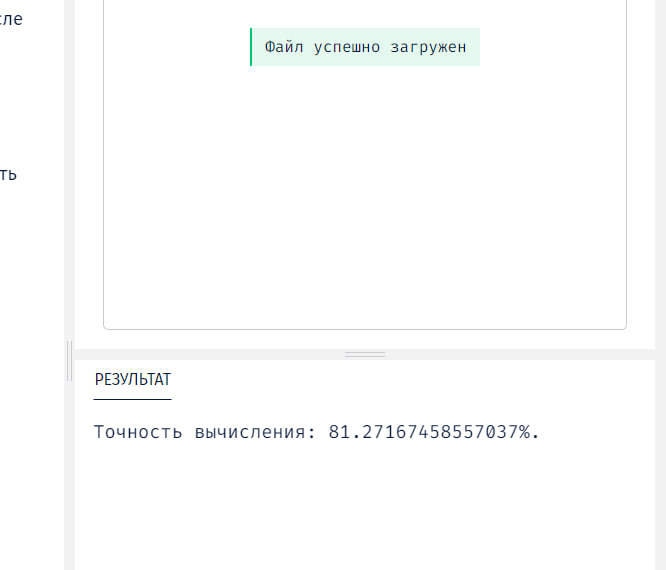